In [272]:
import numpy as np
import pathlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import random
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
import time
import datetime
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay

### Importing eigenfaces

In [273]:
basepath = pathlib.Path('Train.ipynb').parent.absolute()

data = np.load(str(basepath) + r'\PCA_modified_for_gender_classification.npz')

### Labeling of the dataset

In [322]:
labels = {}
for name in data['faces_names']:
    temp = name
    for i in range(10):
        temp = str(temp).replace(str(i), '')

    temp = temp.replace('.jpg', '')
    if temp[-3:] == 'ova':
        labels[name] = 0
    else:
        if name != 'unknown.jpg':
            labels[name] = 1

additional = 'bartal3 bachrata4 buchholcero1 hindicka6 chladna1 lehocka26 medvecka3 ochodnicano2 pardubska1 pazicka1' \
' ribar1 richtarikov1 rostas1 sediva25 skupa1 solan1 tomcsanyiov1 velmovska1 velmovska1 vorobeva1 vrbovska5 zabudla1'

for i in additional.split():

    if i + '.jpg' not in labels.keys():
        print(i)

    labels[i + '.jpg'] = 0

print(f'Number of photos = {len(labels)}')
print(f'Number of men = {len([i for i in labels.values() if i == 1])}')
print(f'Number of women = {len([i for i in labels.values() if i == 0])}')

Number of photos = 348
Number of men = 228
Number of women = 120


### Modification of the data for input

In [275]:
def data_for_input(method, in_lables, in_weights, in_names):
    #association labels with weights
    weights_plus_labels = {}
    for i in range(len(in_weights)):
        temp_name = in_names[i]
        weights_plus_labels[temp_name] = [in_weights[i], in_lables[temp_name]]

    #standard means that the dataset isn't going to be modified at all
    if method == 'standard':
        weights = []
        labels = []
        for val in weights_plus_labels.values():
            weights.append(val[0])
            labels.append(val[1])
        return weights,labels
    else:
        raise Exception('You have chosen incorert method!')

In [276]:
def under_sampling(u_weights, u_labels):
        #divide dataset based on gender
        men_weights = []
        women_weights = []
        for z,val in enumerate(u_labels):
            if val == 1:
                men_weights.append(u_weights[z])
            elif val == 0:
                women_weights.append(u_weights[z])

        #from which sample should values be removed
        temp_arr =  [women_weights, men_weights]
        if len(men_weights) > len(women_weights):
            del_idx = 1
            keep_idx = 0
        elif len(men_weights) < len(women_weights):
            del_idx = 0
            keep_idx = 1
        #if the lenght of categories equal return data set that isn't modified
        else:
            return u_weights, u_labels

        #choose random values to be removed from the category that has more data and remove them
        for i in random.sample(range(0, len(temp_arr[del_idx])), len(temp_arr[del_idx]) - len(temp_arr[keep_idx])):
            temp_arr[del_idx][i] = None
        weights_undersampled_del = [i for i in temp_arr[del_idx] if i is not None]

        #create data to be returned
        weights_under = weights_undersampled_del + temp_arr[keep_idx]
        labels_under = [del_idx for _ in range(int(len(weights_under)/2))] + [keep_idx for _ in range(int(len(weights_under)/2))]

        return weights_under, labels_under

In [277]:
def resample(method, in_weights, in_lables):

    if method == 'rand_over':
        ros = RandomOverSampler(random_state=0)
        X_resampled, y_resampled = ros.fit_resample(weights_inp, labels_inp)
        return X_resampled, y_resampled

    elif method == 'under':
        X_resampled, y_resampled = under_sampling(in_weights, in_lables)
        return X_resampled, y_resampled

    elif method == 'smote':
        X_resampled, y_resampled = SMOTE().fit_resample(in_weights, in_lables)
        return X_resampled, y_resampled

    elif method == 'adasyn':
        X_resampled, y_resampled = ADASYN().fit_resample(in_weights, in_lables)
        return X_resampled, y_resampled

    elif method == 'keep':
        return in_weights, in_lables

### Functions for vizualization

In [279]:
def prec_recall(wei, lab, model, met):

    display = PrecisionRecallDisplay.from_estimator(
        model, wei, lab,name=met
    )
    _ = display.ax_.set_title("2-class Precision-Recall curve")

In [280]:
def confution_matrix(wei, lab, model):

    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        ("Confusion matrix, without normalization", None),
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            wei,
            lab,
            display_labels=['female','male'],
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

### Functions for modelling

In [281]:
def log_reg(weights_train, labels_train, weights_test, labels_test, plot_bool = False):
    logreg = LogisticRegression(max_iter=10000)
    logreg.fit(weights_train, labels_train)
    if plot_bool:
        prec_recall(weights_test, labels_test, logreg, 'Logistic regression')
        confution_matrix(weights_test, labels_test, logreg)
    return f1_score(logreg.predict(weights_test), labels_test)
#sum([logreg.predict(weights_test)[i] == labels_test[i]  for i in range(len(labels_test))]) / len(labels_test)

In [282]:
#RandomForestClassifier
def rfc(weights_train, labels_train, weights_test, labels_test, plot_bool = False):
    rfc_clf = RandomForestClassifier()
    rfc_clf.fit(weights_train, labels_train)
    rfc_prediction = rfc_clf.predict(weights_test)
    if plot_bool:
        prec_recall(weights_test, labels_test, rfc_clf, 'Random forrest')
        confution_matrix(weights_test, labels_test, rfc_clf)
    return f1_score(rfc_prediction, labels_test)
#sum([rfc_prediction[i] == labels_test[i]  for i in range(len(labels_test))]) / len(labels_test)

In [308]:
#Support Vector Classifier
def svc(weights_train, labels_train, weights_test, labels_test, plot_bool = False, avg = False):
    s_clf = SVC()
    s_clf.fit(weights_train, labels_train)
    s_prediction = s_clf.predict(weights_test)
    if plot_bool:
            prec_recall(weights_test, labels_test, s_clf, 'SVC')
            confution_matrix(weights_test, labels_test, s_clf)
    if avg:
        return f1_score(s_prediction, labels_test), sum([s_prediction[i] == labels_test[i]  for i in range(len(labels_test))]) / len(labels_test)
    return f1_score(s_prediction, labels_test)
#sum([s_prediction[i] == labels_test[i]  for i in range(len(labels_test))]) / len(labels_test)

In [284]:
#DecisionTreeClassifier
def dtc(weights_train, labels_train, weights_test, labels_test, plot_bool = False):
    dtc_clf = tree.DecisionTreeClassifier()
    dtc_clf = dtc_clf.fit(weights_train, labels_train)
    dtc_prediction = dtc_clf.predict(weights_test)
    if plot_bool:
        prec_recall(weights_test, labels_test, dtc_clf, 'Decision tree')
        confution_matrix(weights_test, labels_test, dtc_clf)
    return f1_score(dtc_prediction, labels_test)
#sum([dtc_prediction[i] == labels_test[i]  for i in range(len(labels_test))]) / len(labels_test)

### Search for the best combination of (resample method + model + length of basis)

In [285]:
cas = time.time()

log_reg_box, rfc_box, svc_box, dtc_box = ({} for i in range(4))
for i in [5,10,20,30,40,50,70,90,110,135,160,190,250,300]:
    log_reg_box[i] = {}
    rfc_box[i] = {}
    svc_box[i] = {}
    dtc_box[i] = {}

for y in range(100):
    log_reg_arr, rfc_arr, svc_arr, dtc_arr = ([] for i in range(4))
    for i in [5,10,20,30,40,50,70,90,110,135,160,190,250,300]:
        weights_inp , labels_inp  = data_for_input('standard', labels, data[f'weights_{i}'], data['faces_names'])

        for met in ['keep', 'rand_over', 'adasyn', 'smote', 'under']:

            if met == 'adasyn' or met == 'smote':
                weights_train_temp, weights_test, labels_train_temp, labels_test = train_test_split(
                    weights_inp, labels_inp, train_size=0.7, test_size=0.3)
                weights_train, labels_train = resample(met, weights_train_temp, labels_train_temp)
            else:
                res_weights, res_lables = resample(met, weights_inp, labels_inp)
                # split the data to train and test sets
                weights_train, weights_test, labels_train, labels_test = train_test_split(
                        res_weights, res_lables, train_size=0.7, test_size=0.3)
            if y == 0:
                log_reg_box[i][met] = [log_reg(weights_train, labels_train, weights_test, labels_test)]
                rfc_box[i][met] = [rfc(weights_train, labels_train, weights_test, labels_test)]
                svc_box[i][met] = [svc(weights_train, labels_train, weights_test, labels_test)]
                dtc_box[i][met] = [dtc(weights_train, labels_train, weights_test, labels_test)]
            else:
                log_reg_box[i][met].append(log_reg(weights_train, labels_train, weights_test, labels_test))
                rfc_box[i][met].append(rfc(weights_train, labels_train, weights_test, labels_test))
                svc_box[i][met].append(svc(weights_train, labels_train, weights_test, labels_test))
                dtc_box[i][met].append(dtc(weights_train, labels_train, weights_test, labels_test))

print(f'Runtime: {str(datetime.timedelta(seconds=time.time() - cas))}')

C:\Users\ondre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ondre\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Runtime: 0:39:00.907607


### Function for vizualization the results of above-mentioned search

In [286]:
basis_len = [5,10,20,30,40,50,70,90,110,135,160,190,250,300]

In [287]:
def box_plot(var, basis_lengths):
    figure, axis = plt.subplots(3, 2, sharey='row')

    font1 = {'size':20}
    font2 = {'size':15}

    # undersampling
    axis[0, 0].boxplot([np.array(var[i]['under']).T for i in basis_lengths], labels = basis_len)
    axis[0, 0].axhline(y=0.9, xmin=0, xmax=1, color='red', linestyle='--')
    axis[0, 0].axhline(y=0.93, xmin=0, xmax=1, color='yellow', linestyle='--')
    axis[0, 0].set_title("Under-Sampling", font1)
    axis[0, 0].set_ylabel("F1 score", font2)
    axis[0, 0].set_xlabel("Number of parameter in weights", font2)

    # random over-sampling
    axis[0, 1].boxplot([np.array(var[i]['rand_over']).T for i in basis_lengths], labels = basis_len)
    axis[0, 1].axhline(y=0.9, xmin=0, xmax=1, color='red', linestyle='--')
    axis[0, 1].axhline(y=0.93, xmin=0, xmax=1, color='yellow', linestyle='--')
    axis[0, 1].set_title("Random Over-Sampling", font1)
    axis[0, 1].set_ylabel("F1 score", font2)
    axis[0, 1].set_xlabel("Number of parameter in weights", font2)

    # not changing dataset
    axis[1, 0].boxplot([np.array(var[i]['keep']).T for i in basis_lengths], labels = basis_len)
    axis[1, 0].axhline(y=0.9, xmin=0, xmax=1, color='red', linestyle='--')
    axis[1, 0].axhline(y=0.93, xmin=0, xmax=1, color='yellow', linestyle='--')
    axis[1, 0].set_title("Not changing data", font1)
    axis[1, 0].set_ylabel("F1 score", font2)
    axis[1, 0].set_xlabel("Number of parameter in weights", font2)

    # adasyn
    axis[1, 1].boxplot([np.array(var[i]['adasyn']).T for i in basis_lengths], labels = basis_len)
    axis[1, 1].axhline(y=0.9, xmin=0, xmax=1, color='red', linestyle='--')
    axis[1, 1].axhline(y=0.93, xmin=0, xmax=1, color='yellow', linestyle='--')
    axis[1, 1].set_title("ADASYN", font1)
    axis[1, 1].set_ylabel("F1 score", font2)
    axis[1, 1].set_xlabel("Number of parameter in weights", font2)

    #smote
    axis[2, 0].boxplot([np.array(var[i]['smote']).T for i in basis_lengths], labels = basis_len)
    axis[2, 0].axhline(y=0.9, xmin=0, xmax=1, color='red', linestyle='--')
    axis[2, 0].axhline(y=0.93, xmin=0, xmax=1, color='yellow', linestyle='--')
    axis[2, 0].set_title("SMOTE", font1)
    axis[2, 0].set_ylabel("F1 score", font2)
    axis[2, 0].set_xlabel("Number of parameter in weights", font2)

    figure.set_size_inches(25, 25, forward=True)


    # show plot
    plt.show()

### Vizualization of the results

#### Logistic regression

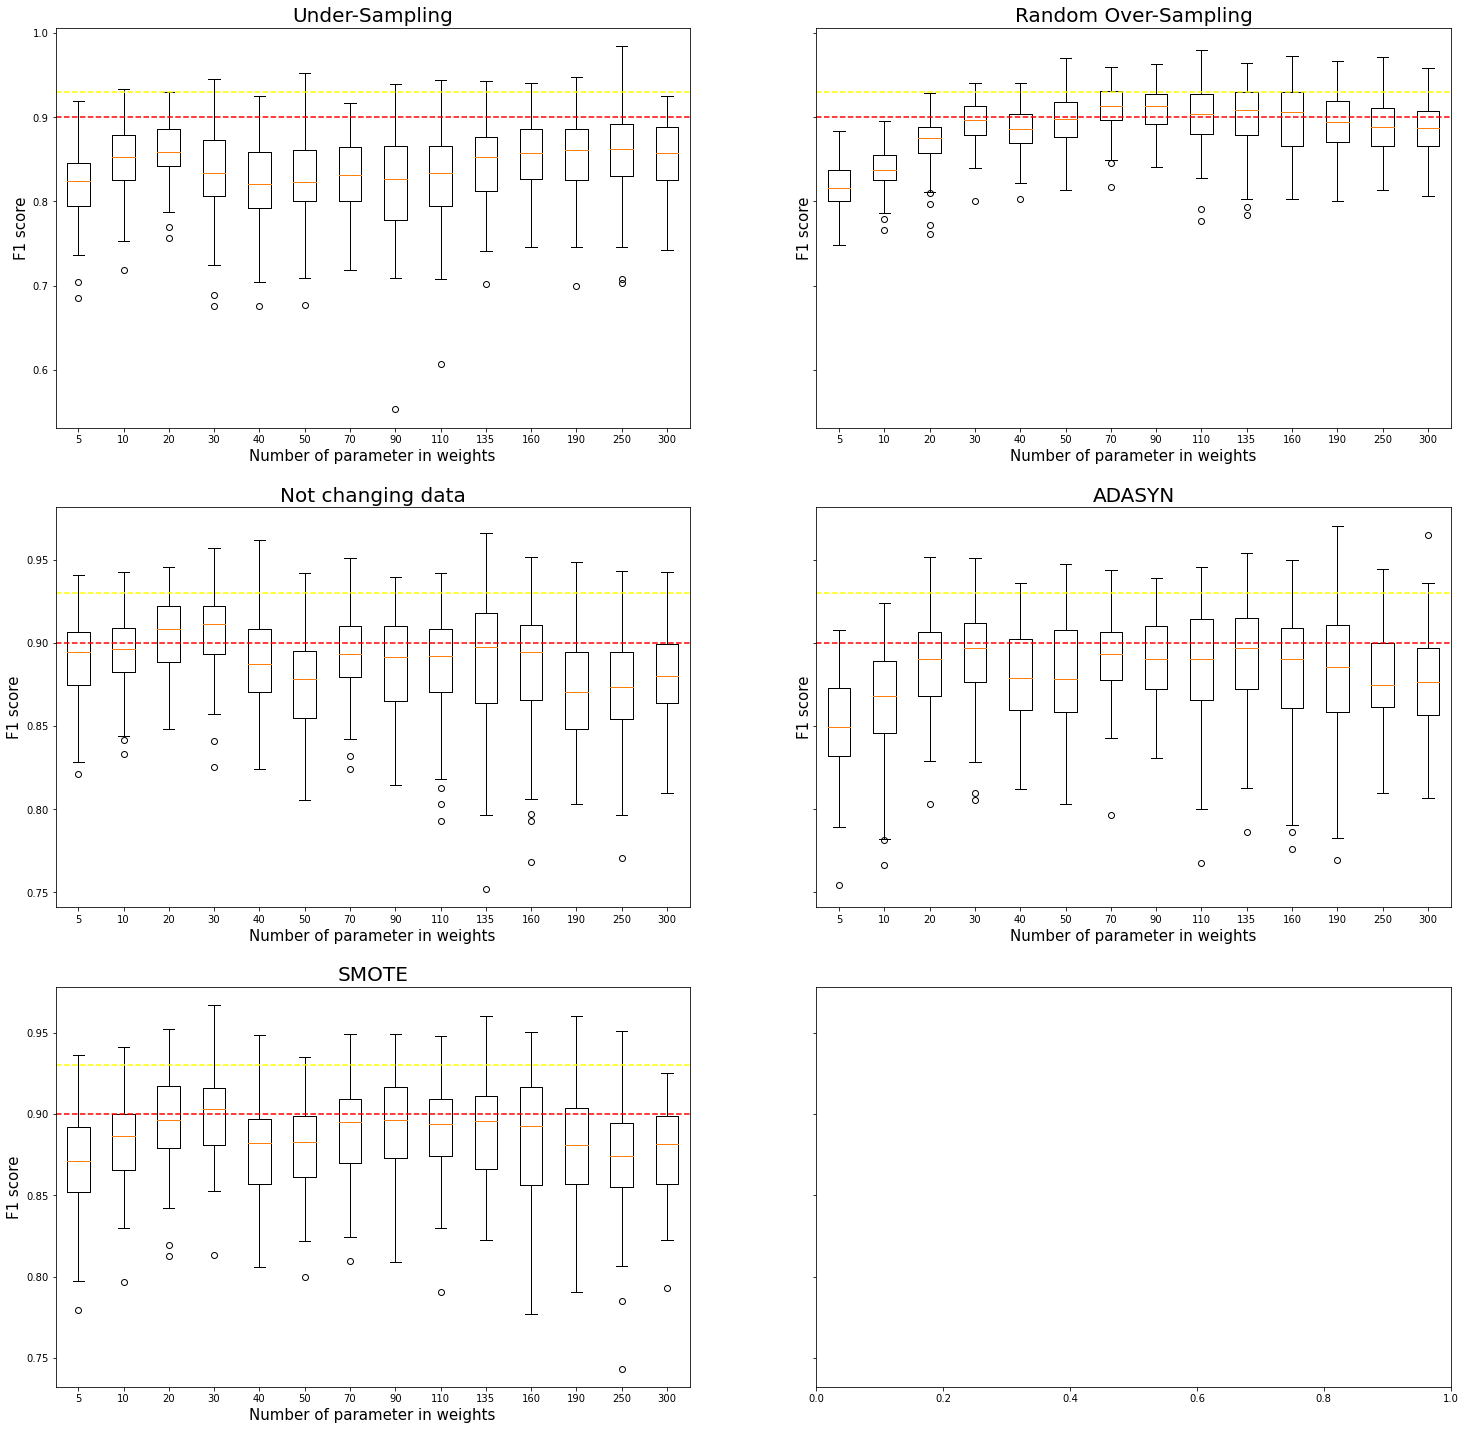

In [288]:
box_plot(log_reg_box, basis_len)

#### Random forrest

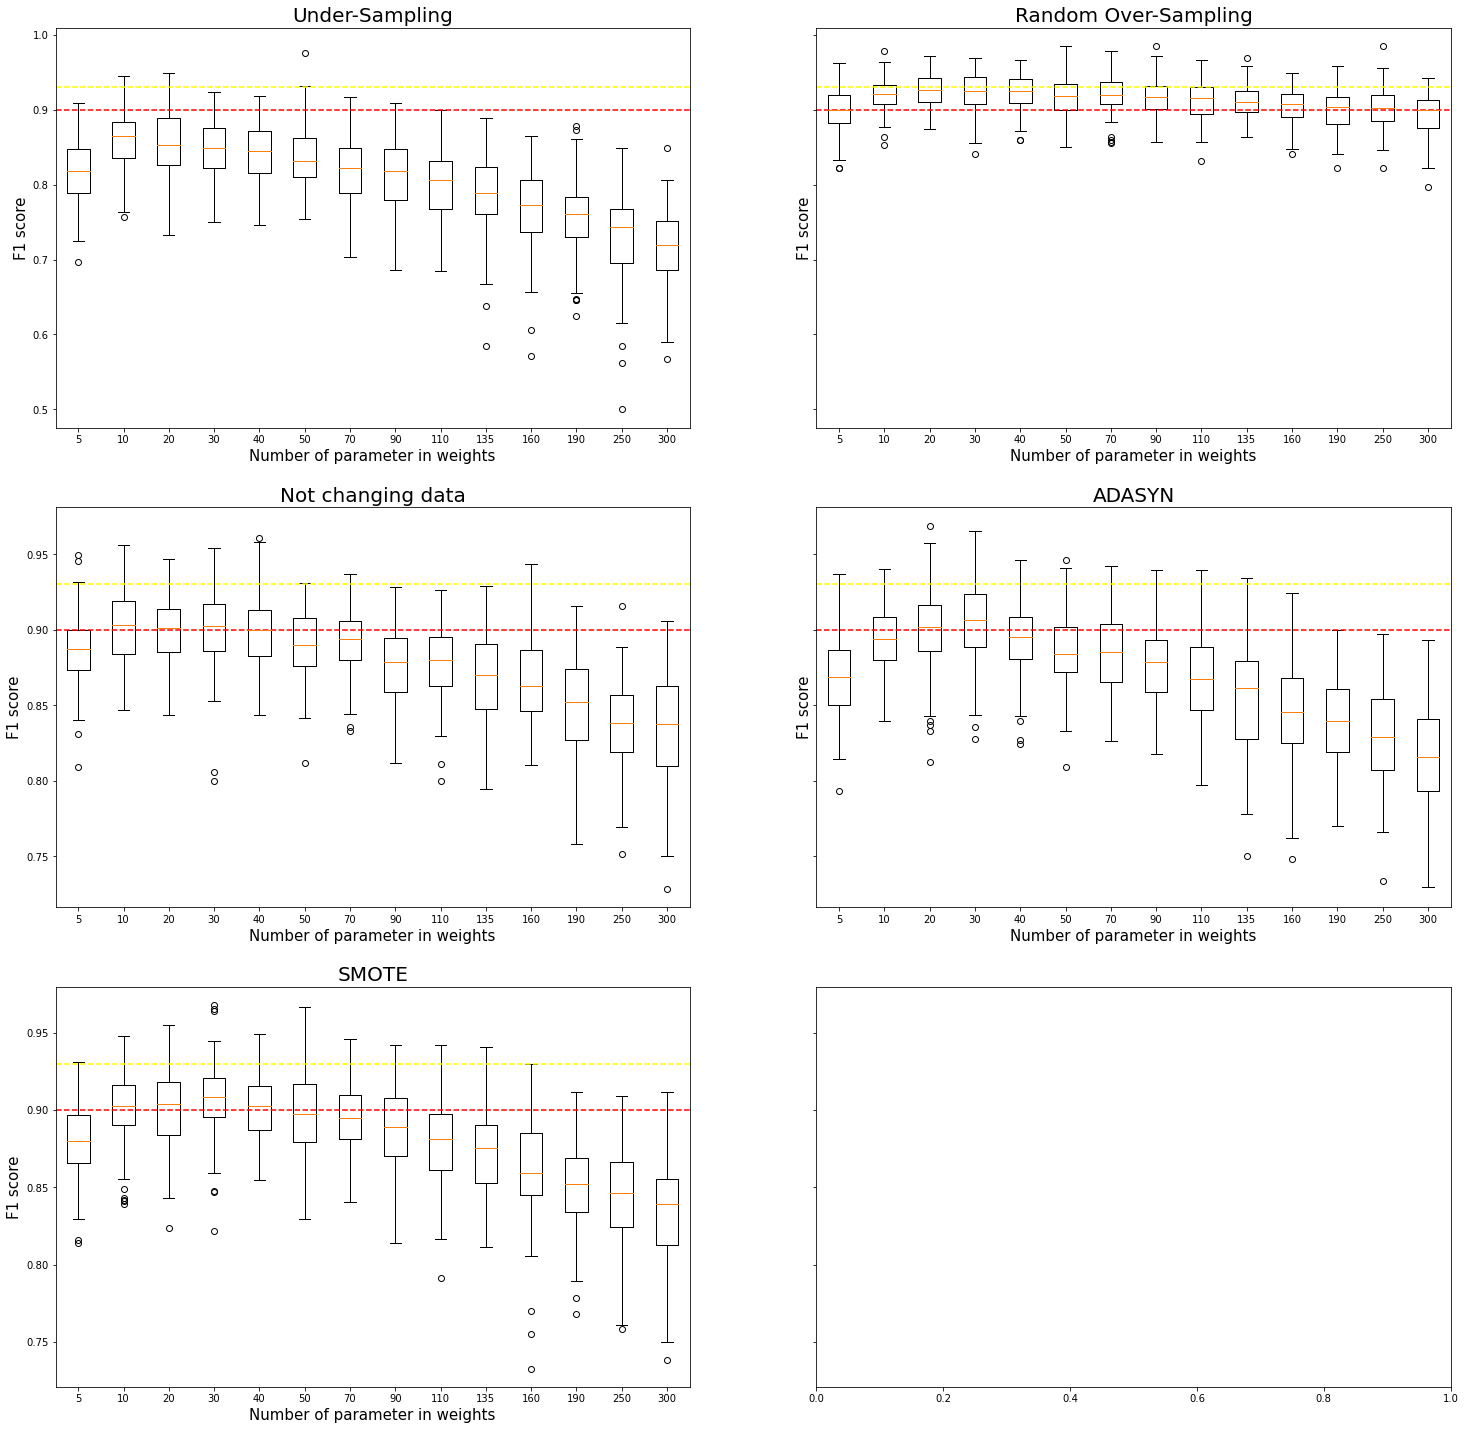

In [289]:
box_plot(rfc_box, basis_len)

#### SVC

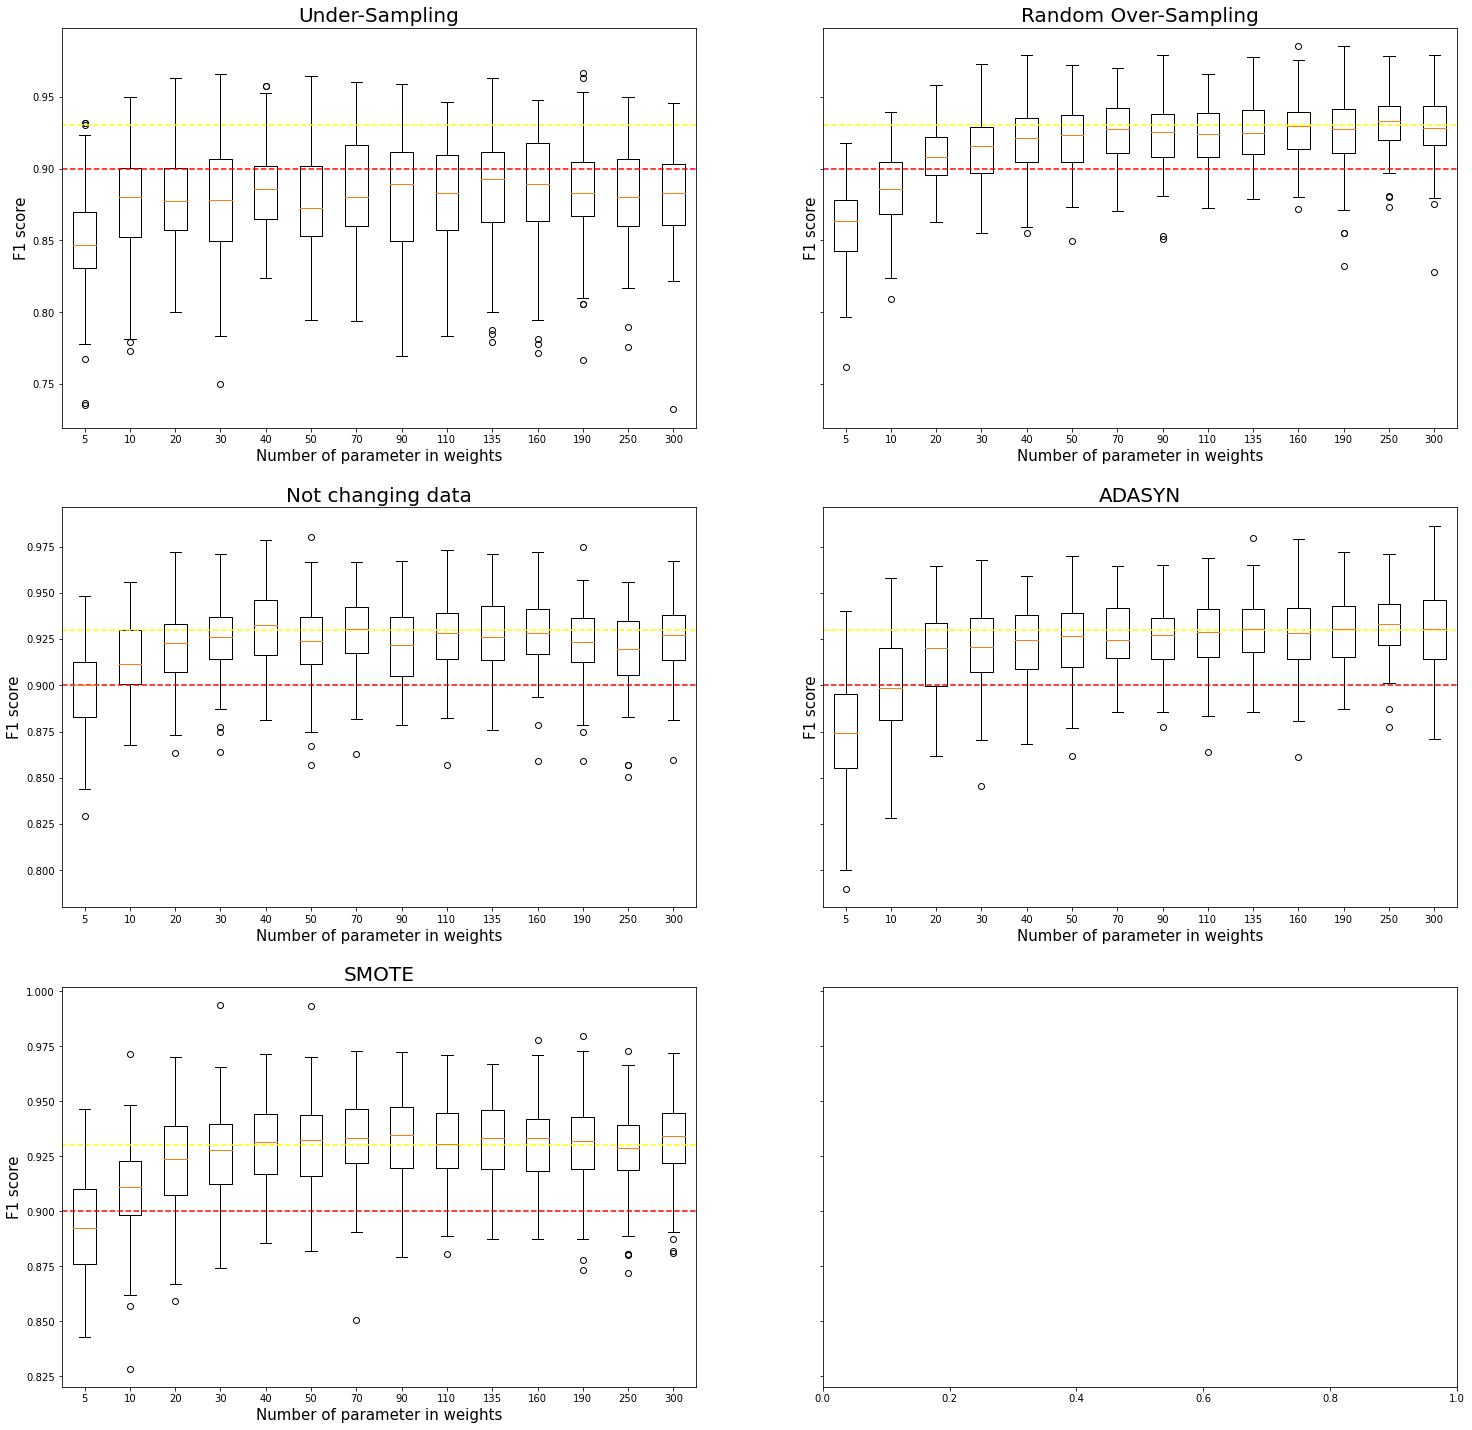

In [290]:
box_plot(svc_box, basis_len)

#### Decision tree

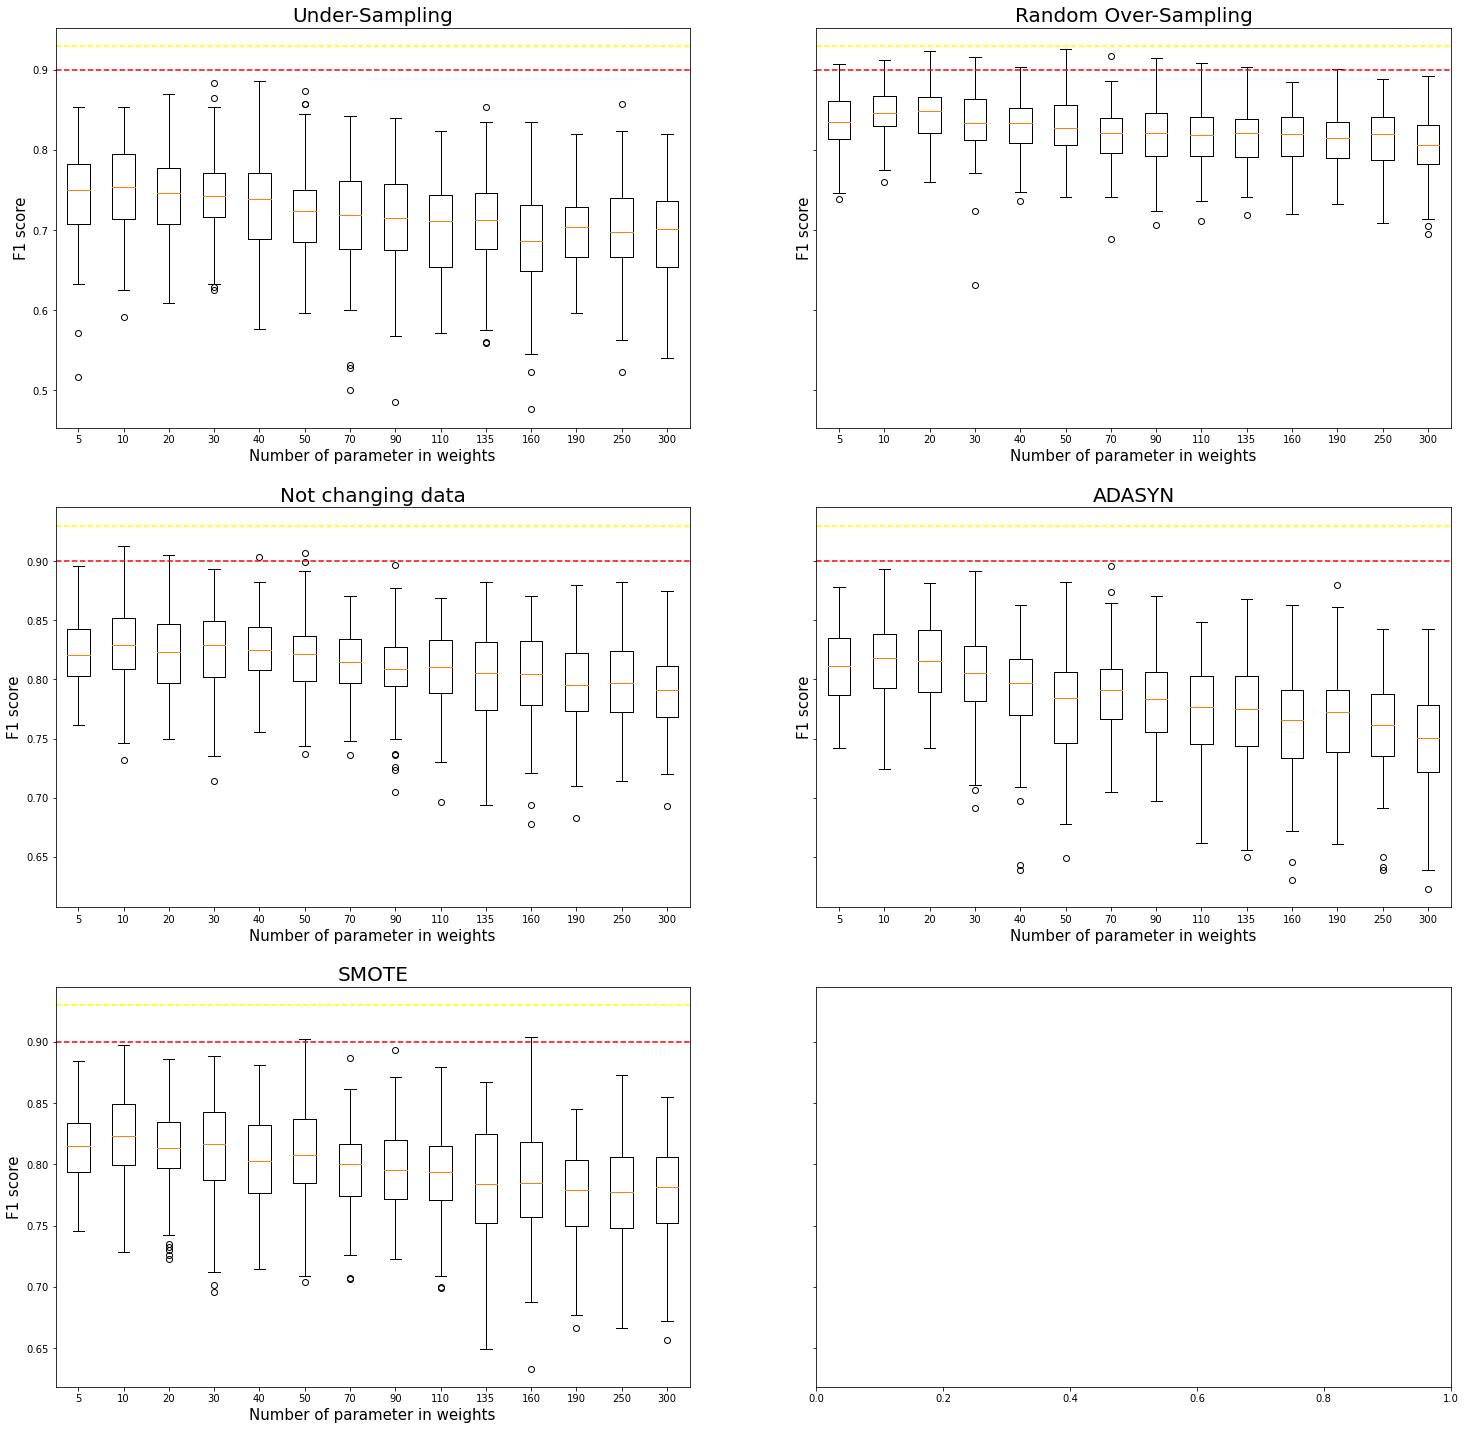

In [291]:
box_plot(dtc_box, basis_len)

### Comparison of the best results

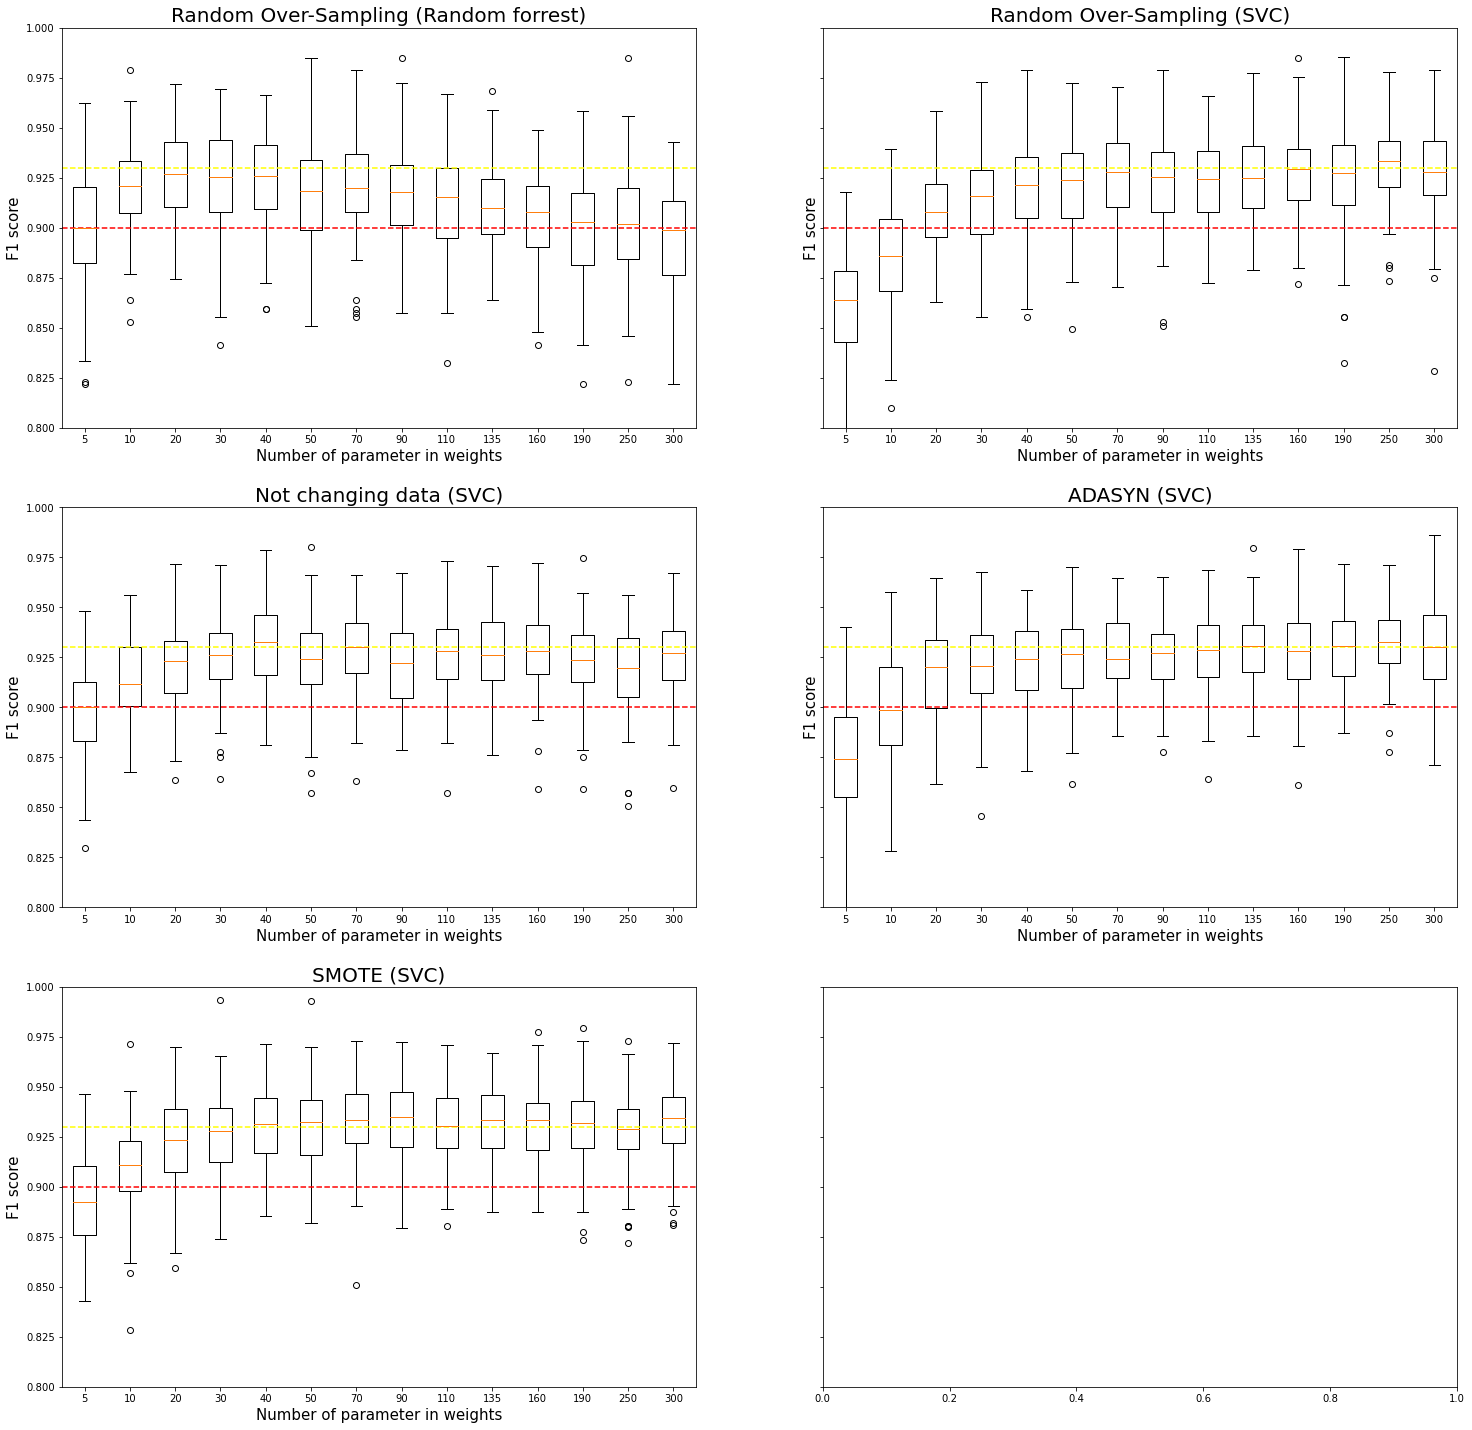

In [323]:
figure, axis = plt.subplots(3, 2, sharey='row')

font1 = {'size': 20}
font2 = {'size': 15}

# undersampling
axis[0, 0].boxplot([np.array(rfc_box[i]['rand_over']).T for i in basis_len], labels=basis_len)
axis[0, 0].axhline(y=0.9, xmin=0, xmax=1, color='red', linestyle='--')
axis[0, 0].axhline(y=0.93, xmin=0, xmax=1, color='yellow', linestyle='--')
axis[0, 0].set_ylim([0.8, 1])
axis[0, 0].set_title("Random Over-Sampling (Random forrest)", font1)
axis[0, 0].set_ylabel("F1 score", font2)
axis[0, 0].set_xlabel("Number of parameter in weights", font2)

# random over-sampling
axis[0, 1].boxplot([np.array(svc_box[i]['rand_over']).T for i in basis_len], labels=basis_len)
axis[0, 1].axhline(y=0.9, xmin=0, xmax=1, color='red', linestyle='--')
axis[0, 1].axhline(y=0.93, xmin=0, xmax=1, color='yellow', linestyle='--')
axis[0, 1].set_title("Random Over-Sampling (SVC)", font1)
axis[0, 1].set_ylabel("F1 score", font2)
axis[0, 1].set_xlabel("Number of parameter in weights", font2)

# not changing dataset
axis[1, 0].boxplot([np.array(svc_box[i]['keep']).T for i in basis_len], labels=basis_len)
axis[1, 0].axhline(y=0.9, xmin=0, xmax=1, color='red', linestyle='--')
axis[1, 0].axhline(y=0.93, xmin=0, xmax=1, color='yellow', linestyle='--')
axis[1, 0].set_ylim([0.8, 1])
axis[1, 0].set_title("Not changing data (SVC)", font1)
axis[1, 0].set_ylabel("F1 score", font2)
axis[1, 0].set_xlabel("Number of parameter in weights", font2)

# adasyn
axis[1, 1].boxplot([np.array(svc_box[i]['adasyn']).T for i in basis_len], labels=basis_len)
axis[1, 1].axhline(y=0.9, xmin=0, xmax=1, color='red', linestyle='--')
axis[1, 1].axhline(y=0.93, xmin=0, xmax=1, color='yellow', linestyle='--')
axis[1, 1].set_title("ADASYN (SVC)", font1)
axis[1, 1].set_ylabel("F1 score", font2)
axis[1, 1].set_xlabel("Number of parameter in weights", font2)

#smote
axis[2, 0].boxplot([np.array(svc_box[i]['smote']).T for i in basis_len], labels=basis_len)
axis[2, 0].axhline(y=0.9, xmin=0, xmax=1, color='red', linestyle='--')
axis[2, 0].axhline(y=0.93, xmin=0, xmax=1, color='yellow', linestyle='--')
axis[2, 0].set_ylim([0.8, 1])
axis[2, 0].set_title("SMOTE (SVC)", font1)
axis[2, 0].set_ylabel("F1 score", font2)
axis[2, 0].set_xlabel("Number of parameter in weights", font2)

figure.set_size_inches(25, 25, forward=True)

# show plot
plt.show()

### Creating and evaluating model based on the best combinations (resample method + model + length of basis)

F1 score: 0.9142857142857143
Percentage of success: 91.24087591240875


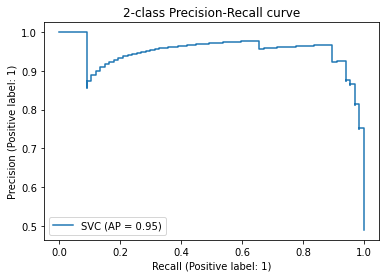

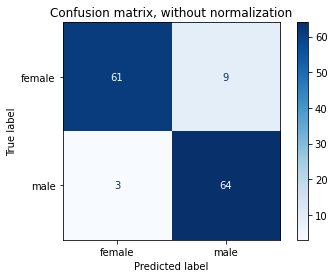

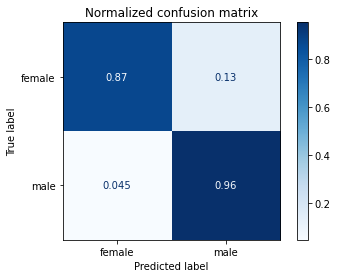

In [320]:
# Random oversampling + SVC + 250
weights_inp, labels_inp = data_for_input('standard', labels, data[f'weights_{250}'], data['faces_names'])

res_weights, res_lables = resample('rand_over', weights_inp, labels_inp)
# split the data to train and test sets
weights_train, weights_test, labels_train, labels_test = train_test_split(
    res_weights, res_lables, train_size=0.7, test_size=0.3)

f1, avg = svc(weights_train, labels_train, weights_test, labels_test, True, True)
print(f'F1 score: {f1}')
print(f'Percentage of success: {avg*100}')

F1 score: 0.927536231884058
Percentage of success: 90.47619047619048


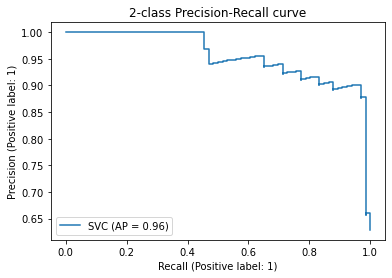

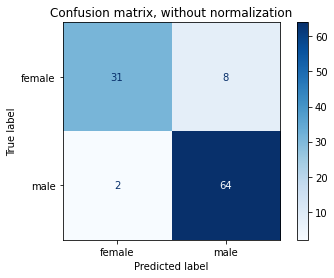

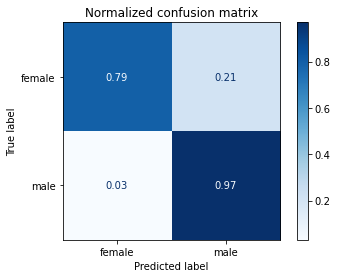

In [342]:
# SMOTE + SVC + 135
weights_inp, labels_inp = data_for_input('standard', labels, data[f'weights_{135}'], data['faces_names'])

# split the data to train and test sets
weights_train, weights_test, labels_train, labels_test = train_test_split(
    weights_inp, labels_inp, train_size=0.7, test_size=0.3)

res_weights, res_labels = resample('smote', weights_train, labels_train)

f1, avg = svc(res_weights, res_labels, weights_test, labels_test, True, True)
print(f'F1 score: {f1}')
print(f'Percentage of success: {avg*100}')